# SnowEx Hackweek GPR Tutorial 2021

**Overview**

In this tutorial we will request the snow pit 1S1 location and density, ground-penetrating radar (GPR) two-way travel-time (TWT) and geolocation data, and Magnaprobe snow depths and location to make a quick comparison of the Magnaprobe snow depth measurements and the GPR estimated snow depths.

We will calculate the average density from the pit and visualize a set of GPR travel-times around Pit 1S1. Given the average dry snow density of 1S1, we will then use an empirically derived expression from Kovacs et. al (1995) to estimate the radar wave speed. The wave speed allows us to convert the radar two-way travel-time to snow depth.

Lastly we will use a few summary statistics to compare the GPR and Magnaprobe snow depths, and we will discuss the various potential sources of error that arise naturally, systematically, and/or algorithmically.

**Slides**

https://docs.google.com/presentation/d/1Hh2CdCCvhWzcWzjzHi9WPum5NmOQt67B1vi1AwOzXCQ/edit?usp=sharing

# Retrieve density, GPR, and Magnaprobe data from Pit 1S1

**Goal**: Compare the Magnaprobe snow depth to the GPR estimated snow depth from SnowEx 2020 Grand Mesa IOP Pit 1S1

 

**Approach**: 

1. Retrieve the pit location from the Layer Data table 
2. Build a circle of 50 m radius around the pit location 
3. Request the Pit Data to get density layers and calculate the avg
4. Request all the GPR data within a 50 m distance of our pit
5. Plot GPR TWT
6. Convert TWT to Depth Using Snow Density
7. Request the Magnaprobe Depths around Pit 1S1
8. Interpolate GPR depths to the locations of the Magnaprobe Depths
9. Compare Statistics of GPR and Magnaprobe Depths


## Process
### Step 1: Get the pit/site coordinates
We must first import the necessary libraries for operating with the SnowEx SQL database.
We then import the Point Data (e.g. GPR) and Layer Data (e.g. snow pit) and GeoPandas, PostGIS, and Python functionality. We also establish the Pit Site ID (1S1) and the buffer radius around the pit (50 m).

In [1]:
## Import our DB access function
from snowexsql.db import get_db

# Import the two tables we need GPR ---> PointData, Density (Pits) --> LayerData 
from snowexsql.data import PointData, LayerData
from snowexsql.conversions import query_to_geopandas

# Import to make use of the postgis functions on the db that are not necessarily in python 
from sqlalchemy import func, Float
# Import datetime module to filter by a date
import datetime 


# use numpy to calculate the average of the density results 
import numpy as np 

# Import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# PIT Site Identifier
site_id = '1S1'

# Distance around the pit to collect data in meters
buffer_dist = 50

# Connect to the database we made.
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab our pit geometry (position) object by provided site id from the site details table, Since there is multiple layers and dates we limit the request to 1
q = session.query(LayerData.geom).filter(LayerData.site_id == site_id).limit(1)
site = q.all()
print(site)

[(<WKBElement at 0x7f7be92ce280; 0101000020206900000000000040a4264100000040877d5041>,)]


### Step 2: Build a buffered circle around our pit

In [2]:
# Cast the geometry point into text to be used by Postgis function ST_Buffer
point = session.query(site[0].geom.ST_AsText()).all()

print(point)

# Create a polygon buffered by our distance centered on the pit using postgis ST_Buffer 
q = session.query(func.ST_Buffer(point[0][0], buffer_dist))
buffered_pit = q.all()[0][0]

[('POINT(741920 4322845)',)]


### Step 3: Grab Density Profiles

We query all Layer Data, cast these values to a float, and then compute the average. Then the query is filtered to only the data type 'density'. The output rho_avg_all is the average density of all snow pits, we also filter the query again by site_id to extract the average density of pit 1S1. These density values are then printed to the screen for comparison.

In [3]:
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to 
# ...accomodate the hand hardness. 
qry = session.query(func.avg(LayerData.value.cast(Float)))

# Filter our query only to density 
qry = qry.filter(LayerData.type=='density')

# Request the data 
rho_avg_all = qry.all()
#print(rho_avg_all)

# Request the Average Density of Just 1S1
rho_avg_1s1 = qry.filter(LayerData.site_id == site_id).limit(1)

# This is a gotcha. The data in layer data only is stored as a string to accomodate the hand hardness values 
print(f"Average density of all pits is {rho_avg_all[0][0]:0.0f} kg/m3")
print(f"Average density of pit 1S1 is {rho_avg_1s1[0][0]:0.0f} kg/m3")

# Cast Densities to float
rho_avg_all = float(rho_avg_all[0][0])
rho_avg_1s1 = float(rho_avg_1s1[0][0])


Average density of all pits is 266 kg/m3
Average density of pit 1S1 is 245 kg/m3


### Step 4: Request all GPR TWT measured inside the buffer
In this step, we first print all of the instruments and data types contained in PointData. Doing so let's us know that in order to query the GPR two-way travel-times we use the identifier 'two_way_travel'. We then apply a filter for the date January 29, 2020, and refine this query further with the filter for TWT only within our buffered region. Using geopandas, the query is cast into a dataframe. By default the queried PointData type is given the name 'value'. To be more explicit we rename the variable as 'twt' within the dataframe.

In [4]:
# Collect all Point Data where the instrument string contains the GPR in its name
#qry = session.query(PointData).filter(PointData.instrument.contains('GPR'))
# Print all types of PointData in the query
tmp = session.query(PointData.instrument).distinct().all()
print(tmp)
# Print all types of PointData in the query
tmp = session.query(PointData.type).distinct().all()
print(tmp)

qry = session.query(PointData).filter(PointData.type == 'two_way_travel')

# Additionally Filter by a date 
qry = qry.filter(PointData.date==datetime.date(2020, 1, 29))

# See upload details at https://github.com/SnowEx/snowexsql/blob/087b382b8d5098f09db67310efd49f777525c0c8/scripts/upload/add_gpr.py#L27

# Grab all the point data in the buffer using the POSTGIS ST_Within, anytime using the postgis functions we typically have to convert to text
qry = qry.filter(func.ST_Within(PointData.geom.ST_AsText(), buffered_pit.ST_AsText()))

# Use our handy dandy function to execute the query and make it a geopandas dataframe
dfGPR = query_to_geopandas(qry, engine)
# rename 'value' in dataframe as 'twt'
dfGPR.rename(columns={'value': 'twt'},inplace=True )


[('mesa',), ('magnaprobe',), ('pulse EKKO Pro multi-polarization 1 GHz GPR',), ('pit ruler',), ('camera-trap',)]
[('swe',), ('depth',), ('two_way_travel',)]


### Step 5: Plot it!

Text(76.87036568247558, 0.5, 'Northing [m]')

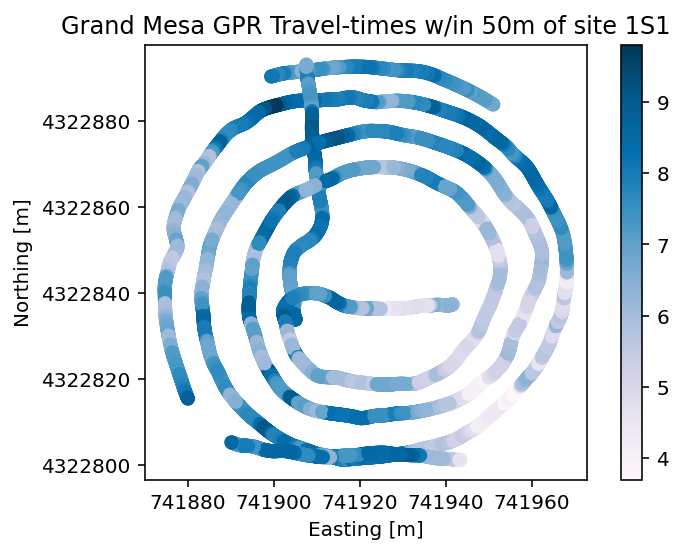

In [5]:
# Get the Matplotlib Axes object from the dataframe object, color points by snow depth value
ax = dfGPR.plot(column='twt', legend=True, cmap='PuBu')


# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title('Grand Mesa GPR Travel-times w/in {}m of site {}'.format(buffer_dist, site_id))
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

### Step 6: Convert TWT to Depth Using Snow Density
We will relate the dry snow density to the electromagnetic wave speed using the Kovacs et. al (1995) formula

$$
\epsilon_{\mathrm{r}}^{\prime}=(1+0.845 \rho)^{2} \quad .
$$ (permitivity)

Equation {eq}`permitivity` calculates the dielectric constant $\epsilon_{\mathrm{r}}^{\prime}$, provided the snow density $\rho$. We must then relate the dielectric constant to the electromagnetic wave speed $(v)$

$$
v = \frac{c}{\sqrt{\epsilon_{\mathrm{r}}^{\prime}}} \quad .
$$ (wavespeed)
In equation {eq}`wavespeed` $c$ is the universal constant $0.3~m/ns$.

We then calculate the depth of the snow 

$$
z = \frac{vt}{2} \quad ,
$$ (depthconversion)

using the two-way travel-time $(t)$ and the electromagnetic velocity.

We add the GPR estimated snow depths to the dataframe, and print the head of the dataframe to confirm this addition.

In [6]:
# Average Snow Density
# all pits
rho = rho_avg_all
# 1s1
rho = rho_avg_1s1
# convert density to specific gravity
rho = rho/1000
# Calculate Dielectric Permittivity of Snow
epsilon = (1+0.845*rho)**2
c = 0.3 # m/ns
v = c/np.sqrt(epsilon) # m/ns
t = dfGPR.twt
z = v*t/2*100
# Add the GPR depths to the datafram
dfGPR['depth'] = z
dfGPR.head()

,site_name,date,time_created,time_updated,id,site_id,doi,date_accessed,instrument,type,...,northing,easting,elevation,utm_zone,geom,time,version_number,equipment,twt,depth
0,Grand Mesa,2020-01-29,2021-06-10 14:54:48.022766+00:00,None,887718,None,https://doi.org/10.5067/Q2LFK0QSVGS2,2021-05-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,...,4322821.215,741887.187,None,12,POINT (741887.187 4322821.215),16:55:56.803000-06:00,None,None,7.6,94.442959
1,Grand Mesa,2020-01-29,2021-06-10 14:54:48.024993+00:00,None,887719,None,https://doi.org/10.5067/Q2LFK0QSVGS2,2021-05-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,...,4322821.131,741887.227,None,12,POINT (741887.227 4322821.131),16:55:56.836000-06:00,None,None,7.6,94.442959
2,Grand Mesa,2020-01-29,2021-06-10 14:54:48.027246+00:00,None,887720,None,https://doi.org/10.5067/Q2LFK0QSVGS2,2021-05-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,...,4322821.046,741887.267,None,12,POINT (741887.267 4322821.046),16:55:56.869000-06:00,None,None,7.6,94.442959
3,Grand Mesa,2020-01-29,2021-06-10 14:54:48.029566+00:00,None,887721,None,https://doi.org/10.5067/Q2LFK0QSVGS2,2021-05-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,...,4322820.961,741887.306,None,12,POINT (741887.306 4322820.961),16:55:56.902000-06:00,None,None,7.6,94.442959
4,Grand Mesa,2020-01-29,2021-06-10 14:54:48.031664+00:00,None,887722,None,https://doi.org/10.5067/Q2LFK0QSVGS2,2021-05-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,...,4322820.876,741887.346,None,12,POINT (741887.346 4322820.876),16:55:56.934000-06:00,None,None,7.6,94.442959


### Step 7: Get Depth Probes
We can recall the PointData types from above in Step 4, and we choose 'depth' as the PointData type filter. Again to ensure we are only considering data that was aquired on the same day as the GPR, we filter the depth data by the date January 29, 2020. We further refine this search to the instrument type 'magnaprobe' and of those data only query the points within our buffer. Lastly, we send this query to a new dataframe using the geopandas functinality, and rename the 'value' column as 'depth'.

In [7]:
# Filter by the dataset type depth
qry = session.query(PointData).filter(PointData.type == 'depth')

# Additionally Filter by a date 
qry = qry.filter(PointData.date==datetime.date(2020, 1, 29))

# Additionally Filter by instrument  
qry = qry.filter(PointData.instrument=='magnaprobe')# and PointData.instrument=='mesa' and PointData.instrument=='pit ruler')
# A Gotcha is how to include all types of instrument

# Grab all the point data in the buffer
qry = qry.filter(func.ST_Within(PointData.geom.ST_AsText(), buffered_pit.ST_AsText()))

# Execute the query
# Use our handy dandy function to execute the query and make it a geopandas dataframe
dfProbe = query_to_geopandas(qry, engine)

# rename Probed Depths to dataframe
dfProbe.rename(columns={'value': 'depth'},inplace=True )
dfProbe.head()

,site_name,date,time_created,time_updated,id,site_id,doi,date_accessed,instrument,type,...,longitude,northing,easting,elevation,utm_zone,geom,time,version_number,equipment,depth
0,Grand Mesa,2020-01-29,2021-06-10 13:06:49.779246+00:00,None,80320,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,-108.20546,4322840.31,741932.13,3036.2,None,POINT (741932.130 4322840.310),07:14:00-06:00,1,CRREL_C,94.0
1,Grand Mesa,2020-01-29,2021-06-10 13:06:49.703341+00:00,None,80286,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,-108.20554,4322850.09,741924.90,3036.1,None,POINT (741924.900 4322850.090),07:10:00-06:00,1,CRREL_C,96.0
2,Grand Mesa,2020-01-29,2021-06-10 13:06:49.705901+00:00,None,80287,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,-108.20554,4322853.04,741924.66,3035.2,None,POINT (741924.660 4322853.040),07:10:00-06:00,1,CRREL_C,93.0
3,Grand Mesa,2020-01-29,2021-06-10 13:06:49.708092+00:00,None,80288,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,-108.20553,4322853.45,741925.81,3035.5,None,POINT (741925.810 4322853.450),07:10:00-06:00,1,CRREL_C,87.0
4,Grand Mesa,2020-01-29,2021-06-10 13:06:49.710224+00:00,None,80289,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,-108.20554,4322854.54,741925.05,3036.1,None,POINT (741925.050 4322854.540),07:11:00-06:00,1,CRREL_C,80.0


### Step 8: Average GPR Depths to Compare with Probed Depths

In this step we will compare the GPR estimated depths to the Magnaprobe depths. In order to accomplish this, we must interpolate the GPR locations to the locations of the probe. We will use inverse distance weighting as our interpolation method.
Example Code taken from https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python

Inverse distance weighting is a weighted average interpolant. The weights are computed as the inverse of the distance between the GPR locations $(x,y)$ and the depth probe locations (the interpolated locations $(x_i,y_i)$) 

$$
d = {\sqrt{(x-x_i)^{2}+(y-y_i)^2}} \quad  \\
w = \frac{1}{d} \quad .
$$ (weights)

Equation {eq}(`weights`) is then normalized 

$$
w = \frac{w}{\sum{w}} \quad ,
$$ (idweights)

to sum to one. For the $i^{th}$ location these weights are multiplied by the GPR depths 

$$
z_i = w_i*z
$$ (applyweights)

to compute a weighted average. 

In the following code implementation of the inverse distance weighting algorithm, the outer method of the universal functions (ufunc) within numpy is called such that the distances are computed in equation {eq}(`weights`) by looping through the interpolation points. The dot product (inner product) is then used to multiply the weights with the GPR depths. This algorithm relies on the use of a for loop within the `unfuc.outer` call, yet it seems quite efficient! A notable caveat of this algorithm, and a source of error, is that the interpolation considers all points in the domain, rather than a localized interpolation. An interpolation scheme that employs a search radius of three meters, rather than 50 meters (as established by the buffer distance in step one), would be preferable. 

We then assign the GPR estimated depths to the probe dataframe, and compute the error between the probed depths and the GPR depths. 

The head of the depth probe dataframe is printed to show that we have added the interpolated GPR depths and the error.

In [8]:
# Inverse Distance Weighting Interpolation
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

# Estimate the GPR Depths at the Probe Locations
z = simple_idw(dfGPR.easting, dfGPR.northing, dfGPR.depth, dfProbe.easting, dfProbe.northing)
# Assign the GPR depths to the Probe dataframe
dfProbe['depthGPR'] = z
# Calculate the Error
err = dfProbe.depth-dfProbe.depthGPR
# Assign the Error to the Probe Dataframe
dfProbe['error'] = err
dfProbe.head()

,site_name,date,time_created,time_updated,id,site_id,doi,date_accessed,instrument,type,...,easting,elevation,utm_zone,geom,time,version_number,equipment,depth,depthGPR,error
0,Grand Mesa,2020-01-29,2021-06-10 13:06:49.779246+00:00,None,80320,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,741932.13,3036.2,None,POINT (741932.130 4322840.310),07:14:00-06:00,1,CRREL_C,94.0,82.689476,11.310524
1,Grand Mesa,2020-01-29,2021-06-10 13:06:49.703341+00:00,None,80286,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,741924.90,3036.1,None,POINT (741924.900 4322850.090),07:10:00-06:00,1,CRREL_C,96.0,86.767049,9.232951
2,Grand Mesa,2020-01-29,2021-06-10 13:06:49.705901+00:00,None,80287,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,741924.66,3035.2,None,POINT (741924.660 4322853.040),07:10:00-06:00,1,CRREL_C,93.0,87.286674,5.713326
3,Grand Mesa,2020-01-29,2021-06-10 13:06:49.708092+00:00,None,80288,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,741925.81,3035.5,None,POINT (741925.810 4322853.450),07:10:00-06:00,1,CRREL_C,87.0,87.169223,-0.169223
4,Grand Mesa,2020-01-29,2021-06-10 13:06:49.710224+00:00,None,80289,None,https://doi.org/10.5067/9IA978JIACAR,2021-05-30,magnaprobe,depth,...,741925.05,3036.1,None,POINT (741925.050 4322854.540),07:11:00-06:00,1,CRREL_C,80.0,87.454136,-7.454136


### Step 9. Plot the Depths, Correlation, and Errors

In this final step, we will compare the GPR depths and probed depths. We compute the Pearson correlation

$$
r=\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}} \quad ,
$$ (pearson)

where $x$ represents the probed depths and $y$ represents the GPR depths.

We calculate the bias of the GPR estimated depths 

$$
\mathrm{MAE}=\frac{\sum_{i=1}^{N}\left|x_{i}-y_{i}\right|}{N} \quad ,
$$ (mae)

as the mean absolute error ($\mathrm{MAE}$). The bias,determined by equation {eq}(`mae`), can be caused by using the incorrect density value. A lower density value will bias the GPR estimated depths to larger values, whereas, a higher density value will bias the GPR depths to lower values. It has also been shown that the point of the probe can enter the soil, which biases the observed depths positively (McGrath et al., 2019). Similarly, the presence of vegitation beneath the snow cover can be a source of air. It is posible that the GPR signal is reflected from the air gap beneath snow that is not grounded. In this case the depth probe may contact the ground, though the GPR travel-time does not, leading to a positive bias. A fourth possible source of error in the comparison of these depths is the disagreement between the size of the GPR "footprint" (known as the fresnel zone radius), which is on the order of one meter, and the area of the probe tip which is about one centimeter. Because these instruments do not sample the same place on the ground, localized varibility in the ground topography can lead to errors between the measured and estimated depths.

The root-mean-square error

$$
\mathrm{RMSE}=\sqrt{\frac{\sum_{i=1}^{N}\left(x_{i}-y_{i}\right)^{2}}{N}}
$$ (rmse)

is a measurement of the standard deviation of the errors, if we assume that the errors are normally distributed and independent.

In the code ection we, first, display these summary statistics. Then we view this information graphically. The first plot is the scatter of the observed depths versus the estimated depths with the regression line. The second plot is a histogram of the errors (observed - estimated). The histogram shows a positive bias, which indicates that a combination of the errors discussed above resulted in the probe measuring greater snow depths than the GPR on average. The final plot displays the errors in depth spatially. Roughly, by eye, it appears that areas with low travel-time ($\sim4~ns$, southeast quadrant) overestimate the depth, interestingly enough!


The correlation is 0.64
The bias is 8.56 cm
The rmse is 10.62 cm


Text(60.245147830207486, 0.5, 'Northing [m]')

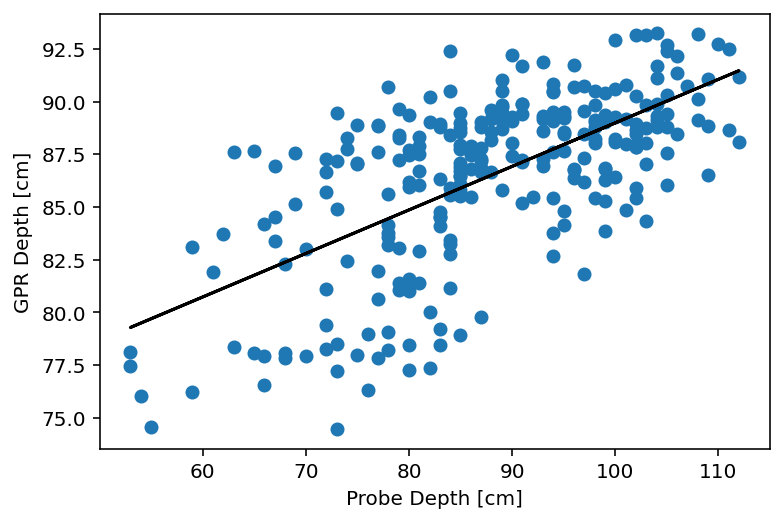

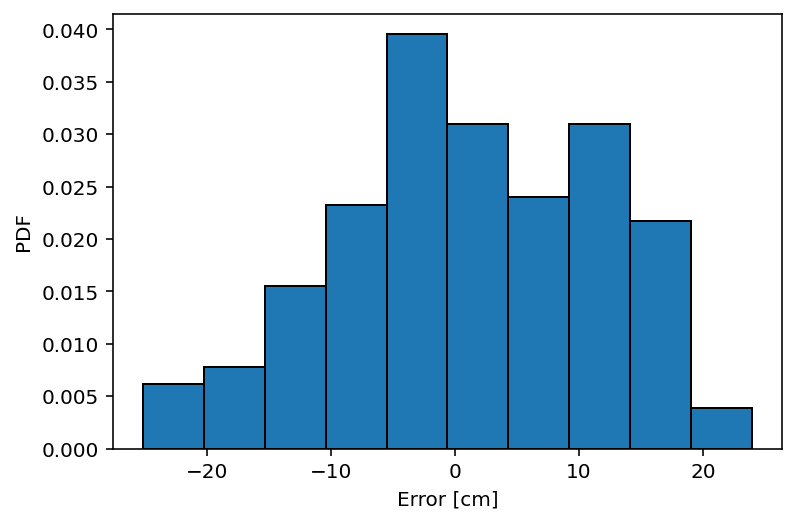

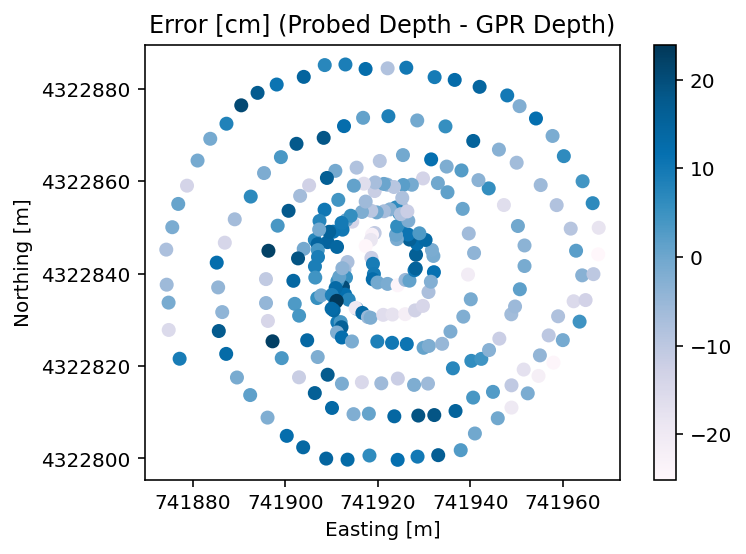

In [9]:
# Calculate the Correlation
r = np.corrcoef(dfProbe.depth,dfProbe.depthGPR)
print('The correlation is', round(r[0,1],2))
# Calculate the Mean Absolute Error
bias = np.mean(np.abs(dfProbe.error))
print('The bias is', round(bias,2), 'cm')
# Calculate the Root Mean Squared Error
rmse = np.sqrt(np.mean((dfProbe.error)**2))
print('The rmse is', round(rmse,2), 'cm')
# Compute the Regression Line
m, b = np. polyfit(dfProbe.depth,dfProbe.depthGPR, 1)

# Plot the Correlation
plt.figure(0)
plt.plot(dfProbe.depth,dfProbe.depthGPR,'o')
plt.plot(dfProbe.depth, m*dfProbe.depth + b,'k')
plt.xlabel('Probe Depth [cm]')
plt.ylabel('GPR Depth [cm]')

# Plot a Histogram of the Errors
plt.figure(1)
plt.hist(dfProbe.error, density=True, bins=10, edgecolor='black')  # density=False would make counts
plt.ylabel('PDF')
plt.xlabel('Error [cm]');
# Get the Matplotlib Axes object from the dataframe object, color points by snow depth value
ax = dfProbe.plot(column='error', legend=True, cmap='PuBu')


# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title('Error [cm] (Probed Depth - GPR Depth)')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')



In [10]:
# Close the session to avoid hanging transactions
session.close()